In [309]:
from astropy.coordinates import Angle, SkyCoord, EarthLocation, AltAz, get_body, ICRS
import astropy.constants as c
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
import astropy.units as u
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import WCSAxes

from matplotlib import patheffects
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from regions import Regions, PolygonSkyRegion

%matplotlib widget

In [310]:
def wrap360(ang):
    return ((ang + 360.) % 360.)

In [311]:
EL_MIN = 20
EL_MAX = 52
az_limleft = lambda x: wrap360(x - 270)
az_limright = lambda x: wrap360(x - 135)

mcmurdo = EarthLocation(lat='-77.8419', lon='166.6863', height=37000.)
launch_date = Time('2026-12-25 00:00:00', scale='utc', location=mcmurdo)

oneday = np.arange(24 + 1) * u.hr
oneweek = np.arange(24 * 7) * u.hr
threeweeks = np.arange(24 * 7 * 3 + 1) * u.hr
times = launch_date + threeweeks
t = (times - times[0]).to(u.hr)

sun_body = get_body('sun', times, location=mcmurdo)
sun = SkyCoord(ra=sun_body.ra, dec=sun_body.dec, obstime=times, location=mcmurdo)
sun_altaz = sun.transform_to('altaz')

gal_center = SkyCoord(ra='17h45m40.04s', dec='-29d00m28.s', obstime=times[0], location=mcmurdo)

goods_s = SkyCoord(ra=3.*15*u.degree,dec=-27*u.degree, obstime=times, location=mcmurdo)
goods_s_altaz = goods_s.transform_to('altaz')

edfs = SkyCoord(ra='04h04m57.84s', dec='-48d25m22.8s', obstime=times[0], location=mcmurdo)

edff = SkyCoord(ra='03h31m43.6s', dec='-28d05m18.6s', obstime=times[0], location=mcmurdo)

foo = SkyCoord.from_name('Vy CMa')
vy_cma = SkyCoord(foo.ra, foo.dec, obstime=times, location=mcmurdo)
vy_cma_altaz = vy_cma.transform_to(AltAz)

f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 361 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 361 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utcut1" yielded 361 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 360 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 360 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yi

(0.0, 504.0)

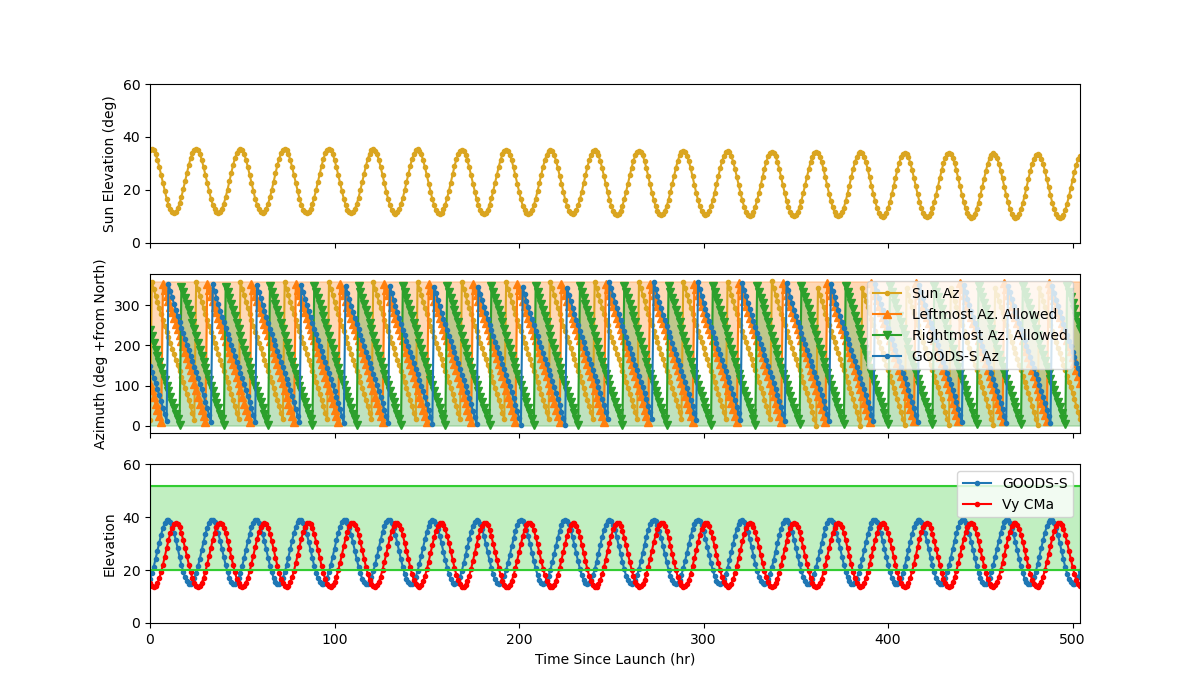

In [312]:
fig, ax = plt.subplots(figsize=(12,7), nrows=3, sharex=True)

ax[0].plot(t, sun_altaz.alt.deg, marker='.', color='goldenrod')
ax[0].set_ylim(0, 60)
ax[0].set_ylabel('Sun Elevation (deg)')

ax[1].plot(t, sun_altaz.az.deg, marker='.', color='goldenrod', label='Sun Az')
ax[1].plot(t, az_limleft(sun_altaz.az.deg), marker='^', color='C1', label='Leftmost Az. Allowed')
ax[1].fill_between(t.value, az_limleft(sun_altaz.az.deg), color='C1', y2=360, alpha=0.3)
ax[1].plot(t, az_limright(sun_altaz.az.deg), marker='v', color='C2', label='Rightmost Az. Allowed')
ax[1].fill_between(t.value, az_limright(sun_altaz.az.deg), color='C2', y2=0, alpha=0.3)
ax[1].plot(t, goods_s_altaz.az.deg, marker='.', label='GOODS-S Az')
ax[1].set_ylabel('Azimuth (deg +from North)')
ax[1].legend(loc='upper right')

ax[2].plot(t, goods_s_altaz.alt.deg, marker='.', label='GOODS-S')
ax[2].plot(t, vy_cma_altaz.alt.deg, marker='.', color='r', label='Vy CMa')
ax[2].axhline(EL_MIN, color='limegreen')
ax[2].fill_between(t.value, EL_MIN, y2=EL_MAX, color='limegreen', alpha=0.3)
ax[2].axhline(EL_MAX, color='limegreen')
ax[2].set_ylim(0, 60)
ax[2].set_xlabel('Time Since Launch (hr)')
ax[2].set_ylabel('Elevation')
ax[2].legend()

ax[2].set_xlim(t[0].value, t[-1].value)

In [313]:
def altaz_to_radec_helper(alt, az):
    my_radec = SkyCoord(
        AltAz(
            alt=alt,
            az=az,
            obstime=times,
            location=mcmurdo
        )
    ).transform_to(ICRS)
    return my_radec

In [314]:
def on_mouse_move(event):
    """Callback function to handle mouse motion events."""
    if event.inaxes == ax:  # Ensure the mouse is over our axes
        # Convert the pixel coordinates to world coordinates
        pixel_coords = np.array([[event.xdata, event.ydata]])
        world_coords = wcs.pixel_to_world_values(pixel_coords)
        # Convert to astropy.coordinates.SkyCoord for formatted output
        sky_coord = SkyCoord(world_coords[0][0], world_coords[0][1],
                             unit=u.degree, frame='icrs')
        s = ('World: RA=' +  sky_coord.ra.to_string(unit=u.hr, precision=1, sep='hms') + ' ' +
            'Dec=' + sky_coord.dec.to_string(unit=u.deg, precision=1, sep='dms'))
        print('\r' + s, end=' ' * len(s) + '\r')

Plot a polygon on sky connecting the RA/Dec coordinates dictated by the el axis limits and the sun. One polygon per time coordinate

In [315]:
# https://alasky.cds.unistra.fr/hips-image-services/hips2fits
# IRIS 100 um allsky
hdu = fits.open("cutout-CDS_P_IRIS_color.fits")
h = hdu[0].header
wcs = WCS(h, naxis=2) # reduce WCS dimensionality for polygon overplot
d0 = hdu[0].data[2, :, :]

In [316]:
# Herschel SPIRE color
hdu = fits.open("cutout-ESAVO_P_HERSCHEL_SPIRE-color.fits")
# hdu = fits.open("cutout-ESAVO_P_Herschel_color.fits")
h = hdu[0].header
wcs = WCS(h, naxis=2) # reduce WCS dimensionality for polygon overplot
d1 = hdu[0].data[2, :, :]

In [317]:
# Herschel SPIRE color
# hdu = fits.open("cutout-ESAVO_P_HERSCHEL_SPIRE-color.fits")
hdu = fits.open("cutout-ESAVO_P_Herschel_color.fits")
h = hdu[0].header
wcs = WCS(h, naxis=2) # reduce WCS dimensionality for polygon overplot
d2 = hdu[0].data[2, :, :]

In [318]:
ds = [d1, d0]

f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 361 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utcut1" yielded 361 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 361 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 361 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
f:\Anaconda3\envs\astr\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utcut1" yielded 361 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yi

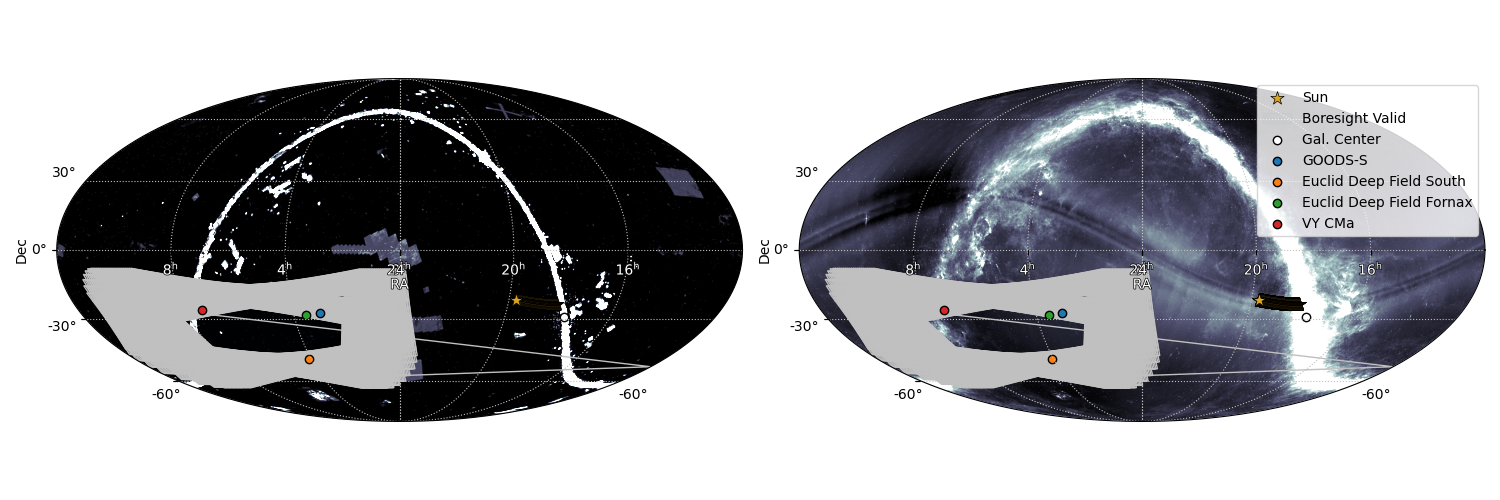

In [319]:
fig, axs = plt.subplots(figsize=(15,5), ncols=2, subplot_kw=dict(projection=wcs, frame_class=EllipticalFrame), sharex=True, sharey=True)
ax0, ax1 = axs

cid = fig.canvas.mpl_connect('motion_notify_event', on_mouse_move)

for j, ax in enumerate(axs):
    d = ds[j]

    lon = ax.coords[0]
    lat = ax.coords[1]
    lat.set_axislabel_position("c")

    path_effects=[patheffects.withStroke(linewidth=1, foreground='black')]
    lon.set_ticklabel(color='white', path_effects=path_effects)
    ax.grid(linestyle=':', color='silver')

    ax.imshow(d, vmin=np.nanmin(d), vmax=np.nanmean(d) + 1 * np.nanstd(d), cmap='bone')

    p = ax.scatter(sun.ra, sun.dec, s=100, marker='*', facecolor='goldenrod', edgecolor='k', linewidth=.5, transform=ax.get_transform('icrs'), label='Sun')

    limleftup_radec = altaz_to_radec_helper(EL_MAX * u.deg, az_limleft(sun_altaz.az.deg) * u.deg)
    limleftdown_radec = altaz_to_radec_helper(EL_MIN * u.deg, az_limleft(sun_altaz.az.deg) * u.deg)
    limrightup_radec = altaz_to_radec_helper(EL_MAX * u.deg, az_limright(sun_altaz.az.deg) * u.deg)
    limrightdown_radec = altaz_to_radec_helper(EL_MIN * u.deg, az_limright(sun_altaz.az.deg) * u.deg)

    # coordinates of corners on plot
    # p = ax.scatter(limleftup_radec.ra, limleftup_radec.dec, marker='.', color='limegreen', alpha=0.1, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limrightup_radec.ra, limrightup_radec.dec, marker='.', color='limegreen', alpha=0.1, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limleftdown_radec.ra, limleftdown_radec.dec, marker='.', color='limegreen', alpha=0.1, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limrightdown_radec.ra, limrightdown_radec.dec, marker='.', color='limegreen', alpha=0.1, transform=ax.get_transform('icrs'))

    rs = []
    for i in range(len(limleftup_radec)):
        verts = SkyCoord([
                limleftup_radec.ra[i],
                limleftdown_radec.ra[i],
                limrightdown_radec.ra[i],
                limrightup_radec.ra[i],
            ],
            [
                limleftup_radec.dec[i],
                limleftdown_radec.dec[i],
                limrightdown_radec.dec[i],
                limrightup_radec.dec[i],
            ],
            unit='deg',
            frame=ICRS
        )
        reg = PolygonSkyRegion(vertices=verts, visual=dict(fill=True, edgecolor='limegreen', facecolor=None))
        rs.append(reg)
    regions = Regions(rs)
    regions.write('myregions.reg', format='ds9', overwrite=True)

    px_regions = [r.to_pixel(wcs) for r in rs]
    for i, p in enumerate(px_regions):
        if i == 0:
            p.plot(ax=ax, edgecolor='k', alpha=max(1/len(times), 0.01), label='Boresight Valid')
        # p.plot(ax=ax, edgecolor='k', alpha=max(1/len(times), 0.01))
        p.plot(ax=ax, facecolor='none', edgecolor='silver', alpha=1)

    # some additional points of interest
    ax.scatter(gal_center.ra, gal_center.dec, facecolor='w', edgecolor='k', transform=ax.get_transform('icrs'), label='Gal. Center')
    ax.scatter(goods_s.ra, goods_s.dec, edgecolor='k', transform=ax.get_transform('icrs'), label='GOODS-S')
    ax.scatter(edfs.ra, edfs.dec, edgecolor='k', transform=ax.get_transform('icrs'), label='Euclid Deep Field South')
    ax.scatter(edff.ra, edff.dec, edgecolor='k', transform=ax.get_transform('icrs'), label='Euclid Deep Field Fornax')
    ax.scatter(vy_cma.ra, vy_cma.dec, edgecolor='k', transform=ax.get_transform('icrs'), label='VY CMa')

    ax.set_xlabel('RA', color='w', path_effects=path_effects)
    ax.set_ylabel('Dec')
    if j == 1:
        ax.legend()
    fig.tight_layout()

In [320]:
a = Angle(1 * u.deg)
a.__format__('.2f')

'1.00 deg'

HH 46
- Herschel?
- SOFIA proposed?
    - GREAT only, narrow line coverage on OI?
    - No HAWC+
- OI 63 um in jet with CO?
- High J CO?
- Possible no Herschel for High J CO
HH 47
SFO 46?
SFO 48?
- Has Herschel

IRAS Vela Bubble?

G247.55-12.27
- No SOFIA
- Much Herschel

7h39m10.0s -40d27m05.1s
- No Herschel within ~4 deg
- WISE/NEOWISE
- Spitzer
- Bunch of Planck PCCS2E 857 GHz point sources, Catalog of Galactic Cold Clumps - cross-check this?